<a href="https://colab.research.google.com/github/soyeunju/ESAA/blob/main/25-1/Assignments/0328_Week4_HM_PGML_TextAnalysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 파머완 ch8. 4~5

p.509-534

## 텍스트 분류 실습 - 20 뉴스그룹 분류

* 텍스트 분류 : 문서가 특정 분류 또는 카테고리에 속하는 것을 예측하는 기법. - ex. 특정 신문 기사 내용이 연예/정치/사회/문화 중 어떤 카테고리에 속하는지 자동으로 분류하거나 스팸 메일 검출 같은 프로그램이 이에 속함. 지도학습 적용
  * 특정 문서의 분류를 학습 데이터를 통해 학습해 모델을 생성한 뒤 이 학습 모델을 이용해 다른 문서의 분류를 예측하는 것
* BOW 모델 단점
  * 희소 행렬 문제 : 대규모의 칼럼으로 구성된 행렬에서 대부분의 값이 0으로 채워지는 행렬을 희소 행렬. 희소 행렬은 일반적으로 ML 알고리즘의 수행 시간과 예측 성능을 떨어뜨리기 때문에 희소 행렬을 위한 특별한 기법이 마련됨.

텍스트를 피처 벡터화로 변환하면 일반적으로 희소 행렬 형태가 된다. 이때 분류를 효과적으로 잘 처리할 수 있는 알고리즘은 로지스틱 회귀, 선형 서포트 벡터 머신, 나이브 베이즈 등. ➡️ 로지스틱 회귀 사용

1. 텍스트 정규화
2. 피처 벡터화 적용 : 카운트 기반 벡터화, TF-IDF 벡터화로 예측 성능 비교 - 피처 벡터화를 위한 파라미터
3. 적합한 머신러닝 알고리즘으로 분류를 학습/예측/평가 - GridSearchCV 기반의 하이퍼 파라미터 튜닝
➡️ Pipeline 객체로 피처 벡터화 파라미터와 GridSearchCV 기반의 하이퍼 파라미터 튜닝을 한꺼번에 수행

## 텍스트 정규화
`fetch_20newsgroups()` API를 이용해 뉴스그룹의 분류를 수행해 볼 수 있는 예제 데이터를 제공

In [2]:
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset = 'all', random_state = 156)

In [3]:
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [4]:
import pandas as pd
print('target 클래스의 값과 분포도 \n', pd.Series(news_data.target).value_counts().sort_index()) # 0~19, 20개
print('target 클래스의 이름들 \n', news_data.target_names)

target 클래스의 값과 분포도 
 0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
Name: count, dtype: int64
target 클래스의 이름들 
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [10]:
print(news_data.data[0]) # 뉴스그룹 기사의 내용뿐만 아니라 뉴스그룹 제목, 작성자, 소속, 이메일 등의 다양한 정보 포함

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
primary concern is complying with stupid helmet laws, carry a real big
spare (you can put a big or small head in a big helmet, bu

`remove` 파라미터를 이용하여 뉴스그룹 기사의 헤더(header), 푸터(footer) 등을 제거.

순수한 텍스트만으로 구성된 기사 내용으로 어떤 뉴스그룹에 속하는지 분류 시행.

In [11]:
from sklearn.datasets import fetch_20newsgroups
# subset='train'으로 학습용 데이터만 추출, remove=('headers', 'footers', 'quotes')로 내용만 추출
train_news = fetch_20newsgroups(subset = 'train', remove = ('headers','footers','quotes'),random_state = 156)

X_train = train_news.data
y_train = train_news.target

# subset='test'으로 테스트 데이터만 추출, remove=('headers', 'footers', 'quotes')로 내용만 추출
test_news= fetch_20newsgroups(subset = 'test', remove = ('headers','footers','quotes'), random_state = 156)

X_test = test_news.data
y_test = test_news.target

print('학습 데이터 크기 {0}, 테스트 데이터 크기 {1}'.format(len(train_news.data),len(test_news.data)))

학습 데이터 크기 11314, 테스트 데이터 크기 7532


### 피처 벡터화 변환과 머신러닝 모델 학습/예측/평가

1) Count 기반

`CountVectorizer`를 이용해 학습 데이터의 텍스트를 피처 벡터화. 테스트 데이터 역시 피처 벡터화를 수행하는데, 반드시 학습 데이터를 이용해 `fit()`이 수행된 `CountVectorizer` 객체를 이용해 테스트 데이터를 변환(`transform`)해야 함.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorization으로 피처 벡터화 변환 수행.
cnt_vect = CountVectorizer()
cnt_vect.fit(X_train)
X_train_cnt_vect = cnt_vect.transform(X_train)

# 학습 데이터로 fit( )된 CountVectorizer를 이용해 테스트 데이터를 피터 벡터화 변환 수행.
X_test_cnt_vect = cnt_vect.transform(X_test) ## 다시 fit을 하거나 fit_transform()을 사용하면 xxxx

print('학습 데이터 텍스트의 CountVectorizer Shape:', X_train_cnt_vect.shape)

학습 데이터 텍스트의 CountVectorizer Shape: (11314, 101631)


이제 `LogisticRegression`을 이용해 뉴스그룹에 대한 분류를 예측 수행

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# LogisticRegression을 이용하여 학습/예측/평가 수행.
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_cnt_vect,y_train)
pred = lr_clf.predict(X_test_cnt_vect)
print('CountVectorized Logistic Regression의 예측 정확도는 {0: .3f}',format(accuracy_score(y_test,pred)))

CountVectorized Logistic Regression의 예측 정확도는 {0: .3f} 0.6168348380244291


2) TF-IDF 기반

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화를 적용해 학습 데이터 세트와 테스트 데이터 세트 변환.
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

# LogisticRegression을 이용해 학습/예측/평가 수행.
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Logistic Regression의 예측 정확도는 0.678


일반적으로 문서 내에 텍스트 가 많고 많은 문서를 가지는 텍스트 분석에서 카운트 벡터화보다는 `TF-IDF` 벡터화가 좋은 예측 결과를 도출

텍스트 분석에서 머신러닝 모델의 성능을 향상시키는 중요한 2가지 방법은

1) 최적의 ML 알고리즘을 선택

2) 최상의 피처 전처리를 수행하는 것

1. `TfidfVectorizer` 클래스의 스톱 워드를 기존 `'None'`에서 `'english'`로 변경
2. `ngram_range`는 기존 (1, 1)에서 (1, 2)로 변경
3. `max_df=300`

In [22]:
# stop words 피처링을 추가하고 ngram을 기본 (1,1)에서 (1,2)로 변경해 피처 벡터화 적용.
tfidf_vect = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_df = 300)
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

lf_clf = LogisticRegression(solver='liblinear')
lf_clf.fit(X_train_tfidf_vect,y_train)
lf_clf.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Vectorized Logistic Regression 의 예측 정확도는 0.678


`GridSearchCV`를 이용해 로지스틱 회귀의 하이퍼파라미터 최적화를 수행

In [23]:
from sklearn.model_selection import GridSearchCV

# 최적 C값 도출 튜닝 수행. CV는 3폴드 세트로 설정.
params = {'C':[0.01,0.1,1,5,10]} # C: 규제(strength of regularization)의 강도를 조절하는 하이퍼파라미터
grid_cv_lr = GridSearchCV(lf_clf, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv_lr.fit(X_train_tfidf_vect, y_train)
print('Logistic Regression best C parameter :', grid_cv_lr.best_params_ )

# 최적 C값으로 학습된 grid_cv로 예측 및 정확도 평가.
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression best C parameter : {'C': 10}
TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.704


### 사이킷런 파이프라인(Pipeline) 사용 및 GridSearchCV와의 결합

사이킷런의 `Pipeline` 클래스를 이용하면 피처 벡터화와 ML 알고리즘 학습/예측을 위한 코드 작성을 한 번에 진행할 수 있음

Pipeline : 데이터의 가공, 변환 등의 전처리와 알고리즘 적용을 마치 '수도관에서 물이 흐르듯' 한 번에 스트림 기반으로 처리한다는 의미

일반적으로 사이킷런 파이프라인 텍스트 기반의 피처 벡터화뿐만 아니라 모든 데이터 전처리 작업과 Estimator를 결합할 수 있음. 예를 들어 스케일링 또는 벡터 정규화, PCA 등의 변환 작업과 분류, 회귀 등의 Estimator를 한 번에 결합할 수 있음.

In [25]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('tfidf_vect',TfidfVectorizer(stop_words = 'english')),
                     ('lr_clf',LogisticRegression(random_state = 156))])

In [26]:
from sklearn.pipeline import Pipeline

# TfidfVectorizer 객체를 tfidf_vect로, LogisticRegression 객체를 lr_clf로 생성하는 Pipeline 생성
pipeline = Pipeline([('tfidf_vect',TfidfVectorizer(stop_words = 'english',ngram_range=(1,2),max_df = 300)),
                     ('lr_clf',LogisticRegression(solver = 'liblinear', C = 10))])

# 별도의 TfidfVectorizer 객체의 fit( ), transform( )과 LogisticRegression의 fit(), predict( )가 필요 없음.
# pipeline의 fit( )과 predict( )만으로 한꺼번에 피처 벡터화와 ML 학습/예측이 가능.
pipeline.fit(X_train,y_train)
pred = pipeline.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Pipeline을 통한 Logistic Regression의 예측 정확도는 0.704


사이킷런은 GridSearchCV 클래스의 생성 파라미터로 Pipeline을 입력해 Pipeline 기반에서도 하이퍼 파라미터 튜닝을 GridSearchCV 방식으로 진행할 수 있게 함.

GridSearchCV에 Pipeline을 입력할 경우

* param_grid의 입력값 설정은 딕셔너리 형태의 Key와 Value 값을 가짐.
* Value를 리스트 형태로 입력한다.
* Key 값으로 'tfidf_vect__ngram_range'와 같이 하이퍼 파라미터명이 객체 변수명과 결합돼 제공됨.(언더바 2개를 연달아 붙인 뒤 파라미터명 결합)

In [32]:
#from sklearn.pipeline import Pipeline

#pipeline = Pipeline([
    #('tfidf_vect', TfidfVectorizer(stop_words = 'english')),
    #('lr_clf', LogisticRegression())
#])

# Pipeline에 기술된 각각의 객체 변수에 언더바(_) 2개를 연달아 붙여 GridSearchCV에 사용될
# 파라미터/하이퍼 파라미터 이름과 값을 설정.
#params = {'tfidf_vect__ngram_range':[(1,1),(1,2),(1,3)],
          #'tfidf_vect__max_df':[100,300,700],
          #'lr_clf__C': [1,5,10]

#}

# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
#grid_cv_pipe = GridSearchCV(pipeline, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
#grid_cv_pipe.fit(X_train,y_train)
#print(grid_cv_pipe.best_params_, grid_cv_pipe.best_score_)

#pred = grid_cv_pipe.predict(X_test)
#print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

## 5. 감성 분석

감성 분석(Sentiment Analysis)은 문서의 주관적인 감성/의견/감정/기분 등을 파악하기 위한 방법으로 소셜 미디어, 여론조사, 온라인 리뷰, 피드백 등 다양한 분야에서 활용

이러한 감성 지수는 긍정 감성 지수와 부정 감성 지수로 구성되며, 지수를 합산해 긍정 감성 또는 부정 감성을 결정.

감성 분석은 머신러닝 관점에서 지도학습과 비지도학습 방식으로 나눌 수 있음

* 지도학습은 학습 데이터와 타깃 레이블 값을 기반으로 감성 분석 학습을 수행한 뒤 이를 기반으로 다른 데이터의 감성 분석을 예측하는 방법으로 일반적인 텍스트 기반의 분류와 거의 동일.

* 비지도학습은 `Lexicon`이라는 일종의 감성 어휘 사전을 이용. `Lexicon`은 감성 분석을 위한 용어와 문맥에 대한 다양한 정보를 가지고 있으며, 이를 이용해 문서의 긍정적, 부정적 감성 여부를 판단.

### 지도학습 기반 감성 분석 실습- IMDB 영화평

지도학습 기반 감성 분석(텍스트 기반의 이진 분류) : 영화평의 텍스트를 분석해 감성 분석 결과가 긍정인지 부정인지 예측하는 모델을 만듦

In [33]:
import pandas as pd

review_df = pd.read_csv('/content/labeledTrainData.tsv', header = 0, sep = '\t', quoting = 3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [34]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

HTML 형식에서 추출해〈br /> 태그가 여전히 존재.〈br /> 문자열은 피처로 만들 필요가 없으니 삭제.

파이썬의 `re` 모듈은 편리하게 정규 표현식을 지원. 정규 표현식 `[^a-zA-Z]`의 의미는 영어 대/소문자가 아닌 모든 문자를 찾는 것

In [35]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />',' ')

# 파이썬의 정규 표현식 모듈인 re를 이용해 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x : re.sub('[^a-zA-Z]',' ',x))

In [36]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id','sentiment'],axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(feature_df,class_df, test_size = 0.3, random_state = 156)
X_train.shape, X_test.shape

((17500, 1), (7500, 1))

`CountVectorizer` 벡터화를 적용해 예측 성능 측정

예측 성능 평가는 이진 분류임을 고려하여 테스트 데이터 세트의 정확도와 ROC-AUC를 모두 측정

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, ngram은 (1, 2)로 설정해 CountVectorization 수행.
# LogisticRegression의 C는 10으로 설정.
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행. predict_proba()는 roc_auc 때문에 수행.
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred), roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8861, ROC-AUC는 0.9503


`TfidfVectorizer` 벡터화를 적용해 다시 예측 성능을 측정

In [41]:
# 스톱 워드는 english, filtering, ngram은 (1, 2)로 설정해 TF-IDF 벡터화 수행.
# LogisticRegression의 C는 10으로 설정.
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]
print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred), roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


tf-idf 기반 피처 벡터화의 예측 성능이 조금 더 나아짐

### 비지도학습 기반 감성 분석 소개
비지도 감성 분석은 Lexicon을 기반으로 함.

Lexicon : 감성만을 분석하기 위해 지원하는 **감성 어휘 사전**

감성 지수(Polarity score) : 감성 사전이 가지고 있는, 긍정(Positive) 감성, 부정(Negative) 감성 정도를 의미하는 수치. 단어의 위치, 주변 단어, 문맥, POS(Part of Speech) 등을 참고해 결정됨.

감성 사전을 구현한 대표격은 NLTK 패키지. NLTK는 많은 서브 모듈을 가지고 있음.

* Lexicon 모듈

* WordNet 모듈 : 방대한 영어 어휘 사전. 시멘틱 정보 제공. 각각의 품사로 구성된 개별 단어를 Synset이라는 개념을 이용해 표현.

* 시멘틱(semantic) : 문맥상 의미.

  ex. Present : 선물, 현재

  ex. 밥 먹었어? : 단순 식사했는지, 안부 묻기

* Synset : 단어가 가지는 문맥, 시멘틱 정보를 제공하는 WordNet의 핵심 개념

NLP 패키지는 시멘틱을 프로그램적으로 인터페이스할 수 있는 다양한 방법을 제공한다. 하지만 예측 성능은 그리 좋지 못하다.

#### SentWordNet을 이용한 감성 분석

SentiWordNet은 WordNet 기반의 synset을 이용.

NLTK 패키지의 WordNet과 유사하게 감성 단어 전용의 WordNet을 구현한 것. WordNet의 Synset 개념을 감성 분석에 적용한 것.

Synset 별로 3가지 감성 점수를 할당

* 긍정 감성 지수 : 해당 단어가 감성적으로 얼마나 긍정적인가를 수치로 나타낸 것
* 부정 감성 지수 : 얼마나 감성적으로 부정적인가를 수치로 나타낸 것
* 객관성 지수 : 긍정/부정 감성 지수와 완전히 반대되는 개념으로, 단어가 감성과 관계없이 얼마나 객관적인지를 수치로 나타낸 것

문장별로 단어들의 긍정 감성 지수와 부정 감성 지수를 합산하여 최종 감성 지수를 계산하고 이에 기반해 감성이 긍정인지 부정인지 결정

In [42]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [43]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성.
synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 개수:', len(synsets)) # 총 18개의 서로 다른 semantic을 가지는 synset 객체가 반환
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 개수: 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


Synset('present.n.01')와 같이 Synset 객체의 파라미터 'present.n.01'은 POS 태그를 나타냄.
* present : 의미
* n : 명사 품사
* 01 : present가 명사로서 가지는 의미가 여러 가지 있어서 이를 구분하는 인덱스

In [44]:
for synset in synsets:
  print('#### Synset name :',synset.name(),'####')
  print('POS :',synset.lexname()) # POS(Part of Speech: 품사)
  print('Definition:',synset.definition()) # 정의
  print('Lemmas:',synset.lemma_names()) # 부명제

#### Synset name : present.n.01 ####
POS : noun.time
Definition: the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas: ['present', 'nowadays']
#### Synset name : present.n.02 ####
POS : noun.possession
Definition: something presented as a gift
Lemmas: ['present']
#### Synset name : present.n.03 ####
POS : noun.communication
Definition: a verb tense that expresses actions or states at the time of speaking
Lemmas: ['present', 'present_tense']
#### Synset name : show.v.01 ####
POS : verb.perception
Definition: give an exhibition of to an interested audience
Lemmas: ['show', 'demo', 'exhibit', 'present', 'demonstrate']
#### Synset name : present.v.02 ####
POS : verb.communication
Definition: bring forward and present to the mind
Lemmas: ['present', 'represent', 'lay_out']
#### Synset name : stage.v.01 ####
POS : verb.creation
Definition: perform (a play), especially on a stage
Lemmas: ['stage', 'present', 'represent']
#### Synset na

WordNet은 어떤 어휘와 다른 어휘 간의 관계를 유사도로 나타낼 수 있음. `path_similarity()`메서드 활용.

In [47]:
# synset 객체를 단어별로 생성
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree, lion, tiger, cat, dog]
similarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset과 유사도를 측정합니다
for entity in entities:
  similarity = [round(entity.path_similarity(compared_entity),2) for compared_entity in entities]
  similarities.append(similarity)

# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFrame 형태로 저장합니다.
similarity_df = pd.DataFrame(similarities, columns = entity_names, index=entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


SentiWordNet은 WbrdNet의 Synset과 유사한 Senti_Synset 클래스를 가지고 있음. `senti_synset`

In [48]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type:', type(senti_synsets))
print('senti_synsets() 반환 값 개수:', len(senti_synsets))
print('senti_synsets() 반환 값:', senti_synsets)

senti_synsets() 반환 type: <class 'list'>
senti_synsets() 반환 값 개수: 11
senti_synsets() 반환 값: [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


SentiSynset 객체는 단어의 감성을 나타내는 감성 지수와 객관성을(감성과 반대) 나타내는 객관성 지수를 가지고 있음.

어떤 단어가 전혀 감성적이지 않으면 객관성 지수는 1이 되고, 감성 지수는 모두 0이 됨.

In [51]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수:',father.pos_score())
print('father 부정감성 지수:',father.neg_score())
print('father 객관성지수:',father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수:', fabulous.pos_score())
print('fabulous 부정감성 지수:', fabulous.neg_score())

father 긍정감성 지수: 0.0
father 부정감성 지수: 0.0
father 객관성지수: 1.0


fabulous 긍정감성 지수: 0.875
fabulous 부정감성 지수: 0.125


#### SentWordNet을 이용한 감상평 감성 분석
1. 문서(Document)를 문장(Sentence) 단위로 분해
2. 다시 문장을 단어(Word) 단위로 토큰화하고 품사 태깅
3. 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
4. senti_synset 객체에서 긍정 감성/부정 감성 지수를 구하고 이를 모두 합산해 특정 임계치 값 이상일 때 긍정 감성으로, 그렇지 않을 때는 부정 감성으로 결정

품사 태깅 내부 함수 생성

In [55]:
from nltk.corpus import wordnet as wn

# 간단한 NTLK PennTreebank Tag를 기반으로 WordNet기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return

In [56]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화
    sentiment = 0.0
    tokens_count = 0

    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word , tag in tagged_sentence:

            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN , wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성.
            synsets = wn.synsets(lemma , pos=wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산.
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
            tokens_count += 1

    if not tokens_count:
        return 0

    # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
    if sentiment >= 0 :
        return 1

    return 0

In [57]:
review_df['preds'] = review_df['review'].apply( lambda x : swn_polarity(x) )
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix( y_target, preds))
print("정확도:", np.round(accuracy_score(y_target , preds), 4))
print("정밀도:", np.round(precision_score(y_target , preds),4))
print("재현율:", np.round(recall_score(y_target, preds), 4))

[[7669 4831]
 [3635 8865]]
정확도: 0.6614
정밀도: 0.6473
재현율: 0.7092


#### VADER을 이용한 감성 분석
VADER는 소셜 미디어의 감성 분석 용도로 만들어진 룰 기반의 Lexicon. VADER는 SentimentlntensityAnalyzer 클래스를 이용해 쉽게 감성 분석을 제공

`polarity_scores()` 메서드를 통해 감성 점수를 구함.

딕셔너리 형태의 감성 점수를 반환.

'neg'는 부정 감성 지수, 'neu'는 중립적인 감성 지수, 'pos'는 긍정 감성 지수, 'compound'는 neg, neu, pos score를 적절히 조합해 —1에서 1 사이의 감성 지수를 표현한 값.

compound score를 기반으로 부정 감성 또는 긍정 감성 여부를 결정. 보통 0.1 이상이면 긍정 감성, 그 이하이면 부정 감성으로 판단하나 상황에 따라 이 임계값을 적절히 조정해 예측 성능을 조절.

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [60]:
def vader_polarity(review,threshold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)

    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply( lambda x : vader_polarity(x, 0.1) )
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix( y_target, vader_preds))
print("정확도:", np.round(accuracy_score(y_target , vader_preds),4))
print("정밀도:", np.round(precision_score(y_target , vader_preds),4))
print("재현율:", np.round(recall_score(y_target, vader_preds),4))

[[ 6747  5753]
 [ 1858 10642]]
정확도: 0.6956
정밀도: 0.6491
재현율: 0.8514


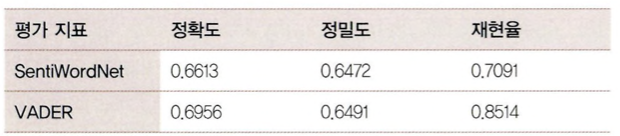